In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/NLP/model_output.zip" -d "/content/model_output"

Archive:  /content/drive/MyDrive/NLP/model_output.zip
   creating: /content/model_output/content/model_output/
   creating: /content/model_output/content/model_output/sdoh_extracotor_gpt/
   creating: /content/model_output/content/model_output/sdoh_extracotor_gpt/checkpoint-2650/
  inflating: /content/model_output/content/model_output/sdoh_extracotor_gpt/checkpoint-2650/optimizer.pt  
  inflating: /content/model_output/content/model_output/sdoh_extracotor_gpt/checkpoint-2650/config.json  
  inflating: /content/model_output/content/model_output/sdoh_extracotor_gpt/checkpoint-2650/training_args.bin  
  inflating: /content/model_output/content/model_output/sdoh_extracotor_gpt/checkpoint-2650/generation_config.json  
  inflating: /content/model_output/content/model_output/sdoh_extracotor_gpt/checkpoint-2650/trainer_state.json  
  inflating: /content/model_output/content/model_output/sdoh_extracotor_gpt/checkpoint-2650/rng_state.pth  
  inflating: /content/model_output/content/model_output/

In [4]:
def load_model_and_tokenizer(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    return model, tokenizer

In [5]:
def generate_text(model, tokenizer, sequence, max_length=10):
    ids = tokenizer.encode(sequence, return_tensors='pt')
    final_outputs = model.generate(
        ids,
        max_length=max_length + len(ids[0]),
        pad_token_id=tokenizer.eos_token_id,
        top_k=10,
        top_p=1,
    )
    generated_text = tokenizer.decode(final_outputs[0], skip_special_tokens=True)
    return generated_text

In [6]:
def process_clinical_notes(txt_file_path, model, tokenizer, output_file_path):
    with open(txt_file_path, 'r', encoding='utf-8') as f, \
         open(output_file_path, 'w', encoding='utf-8') as out_f:
         i=0
         for line in f:
            if i% 2 ==0: # Extract just the clinical note from each line
              note = line.strip().split('\n')[0]
              # print(note)
              generated_text = generate_text(model, tokenizer, note, max_length=150)
              out_f.write(f"Generated Prediction: {generated_text}\n\n")
              # print(generated_text)

            else: pass
            i=i+1

In [7]:
txt_file_path = "/content/test.txt"  # Update this path to your test dataset text file
output_file_path = "/content/output_gpt/predicted_labels.txt"  # Output file for predictions

In [8]:
os.makedirs('/content/output_gpt', exist_ok=True)
model_path = "/content/model_output/content/model_output/sdoh_extracotor_gpt"  # Adjust if necessary
txt_file_path = "/content/test.txt"  # Update this path to your test dataset text file
output_file_path = "/content/output_gpt/predicted_labels.txt"  # Output file for predictions

In [9]:
# Load model and tokenizer
model, tokenizer = load_model_and_tokenizer(model_path)

# Process and generate predictions
process_clinical_notes(txt_file_path, model, tokenizer, output_file_path)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `10` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `10` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


In [10]:
import pandas as pd
import re

def extract_info_and_create_csv(input_file_path, output_csv_path):
    # Pattern to match the lines and extract relevant parts
    pattern = re.compile(r'Generated Prediction: Get the SDOH_LABEL and ADVERSE_LABEL from the following clinical note: (.+) \[SDOH_LABEL\]: (\w+) \[ADVERSE_LABEL\]: (\w+)')

    # Initialize lists to hold extracted information
    notes = []
    sdoh_labels = []
    adverse_labels = []

    with open(input_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Check if line matches the expected starting text
            match = pattern.match(line)
            if match:
                # Extract information from the matched groups
                note, sdoh_label, adverse_label = match.groups()
                notes.append(note)
                sdoh_labels.append(sdoh_label)
                adverse_labels.append(adverse_label)

    # Create a DataFrame from the extracted information
    df = pd.DataFrame({
        'Note': notes,
        'SDOH_LABEL': sdoh_labels,
        'ADVERSE_LABEL': adverse_labels
    })

    # Write the DataFrame to a CSV file
    df.to_csv(output_csv_path, index=False)

# Define input and output paths
input_file_path = "/content/output_gpt/predicted_labels.txt"
output_csv_path = "/content/output_gpt/predictions.csv"

# Call the function to extract information and create the CSV
extract_info_and_create_csv(input_file_path, output_csv_path)

SDOH Label Accuracy: 85.56%
Adverse Label Accuracy: 91.11%


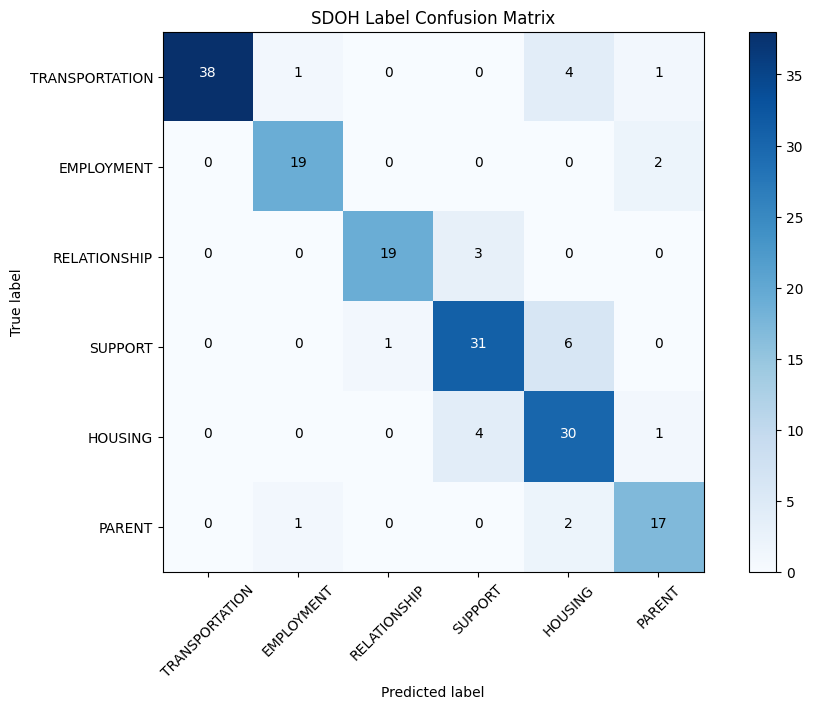

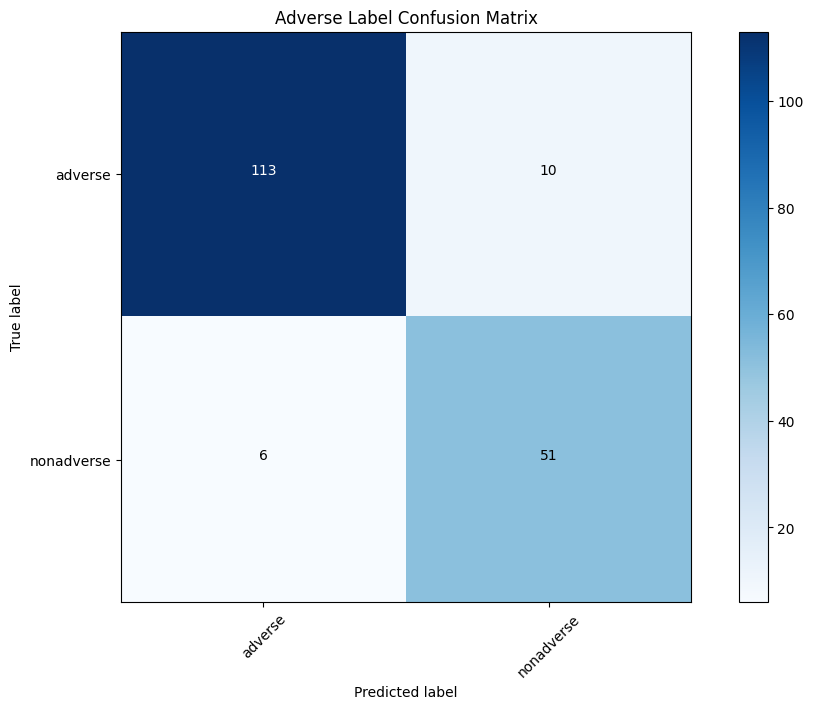

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load true labels and predicted labels from CSV files
true_labels_df = pd.read_csv('/content/test_data.csv')
predicted_labels_df = pd.read_csv('/content/output_gpt/predictions.csv')

# Assuming the structure of both files is: ['Note', 'SDOH_LABEL', 'ADVERSE_LABEL']
# And that the rows in both files are aligned

# Calculate accuracies
sdoh_accuracy = accuracy_score(true_labels_df['label'], predicted_labels_df['SDOH_LABEL'])
adverse_accuracy = accuracy_score(true_labels_df['adverse'], predicted_labels_df['ADVERSE_LABEL'])

print(f"SDOH Label Accuracy: {sdoh_accuracy * 100:.2f}%")
print(f"Adverse Label Accuracy: {adverse_accuracy * 100:.2f}%")

# Calculate confusion matrices
sdoh_cm = confusion_matrix(true_labels_df['label'], predicted_labels_df['SDOH_LABEL'])
adverse_cm = confusion_matrix(true_labels_df['adverse'], predicted_labels_df['ADVERSE_LABEL'])

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting confusion matrices
# You need to replace `unique_labels` with the actual labels used in your dataset.
# For SDOH_LABEL
unique_sdoh_labels = true_labels_df['label'].unique()
plt.figure(figsize=(10, 7))
plot_confusion_matrix(sdoh_cm, classes=unique_sdoh_labels, title='SDOH Label Confusion Matrix')
plt.show()

# For ADVERSE_LABEL
unique_adverse_labels = true_labels_df['adverse'].unique()
plt.figure(figsize=(10, 7))
plot_confusion_matrix(adverse_cm, classes=unique_adverse_labels, title='Adverse Label Confusion Matrix')
plt.show()
